# Building Predictive models Classifier

In [1]:
import pandas as pd
import os
import numpy as np

def load_dataset(subfolder='', file='aapl.us.txt', data_type='raw', index_column=0):
    data_path = os.path.join(os.path.pardir, 'data', data_type, subfolder, file)
    print('Opening file ', data_path)
    df = pd.read_csv(data_path, index_col=index_column)
    print('%d missing values found' % df.isnull().sum().sum())
    return df

def generate_train_dataset(dataset, split_date='2016-01-01'):
    dataset_aux = dataset[dataset.Date < split_date]
    result_df = pd.DataFrame()
    result_df['Label'] = dataset_aux.Label
    result_df['Index'] = dataset_aux.index
    dataset_aux = dataset_aux.drop(columns=['Tomorrow_Date', 'Tomorrow_Open','Label','Diff_Tomorrow_Open','Date','Yesterday_Date']) 
    return dataset_aux, result_df


def generate_train_dataset_lowerbound(dataset, split_date='2016-01-01', lower_bound = '2000-01-01'):
    dataset_aux = dataset[(dataset.Date < split_date) & (dataset.Date > lower_bound)]
    result_df = pd.DataFrame()
    result_df['Label'] = dataset_aux.Label
    result_df['Index'] = dataset_aux.index
    dataset_aux = dataset_aux.drop(columns=['Tomorrow_Date', 'Tomorrow_Open','Label','Diff_Tomorrow_Open','Date','Yesterday_Date']) 
    return dataset_aux, result_df


def generate_test_dataset(dataset, split_date='2016-01-01'):
    dataset_aux = dataset[dataset.Date > split_date]
    result_df = pd.DataFrame()
    result_df['Label'] = dataset_aux.Label
    result_df['Index'] = dataset_aux.index
    dataset_aux = dataset_aux.drop(columns=['Tomorrow_Date', 'Tomorrow_Open','Label','Diff_Tomorrow_Open','Date','Yesterday_Date']) 
    return dataset_aux, result_df


# Prediction and metrics methods

In [2]:
import pandas as pd
import sklearn
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.utils.multiclass import unique_labels

def create_predictions_dataset(test_df, model, X_test):
    predictions = model.predict(X_test)
    df_predicted = pd.DataFrame({ 'Label' : predictions, 'Index' : test_df.index} )
    return df_predicted


def compare_prediction_visual(df_predicted, df_real, model_name='Unknown model'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True, sharex=True, facecolor='w', edgecolor='k', dpi=80)
    title = model_name + ' ' +  'classification results'
    df_predicted.plot(kind='scatter', x='Index',y='Label', ax=axs[0], title='Prediction results')
    df_real.plot(kind='scatter', x='Index',y='Label', ax=axs[1] ,title='Real classification results')
    visualization_path = os.path.join(os.path.pardir, 'reports', 'figures', 'classifier', model_name)
    plt.savefig('{0}.png'.format(visualization_path))


def get_model_metrics(model, y_test, X_test, model_name='Unknown model'):
    result = model.score(X_test, y_test)
    print ('Metrics for model: {}'.format(model_name))
    print ('\tScore: {1:.2f}'.format(model_name, result))
    print ('\tAccuracy: {0:.2f}'.format(accuracy_score(y_test, model.predict(X_test))))
    import warnings
    warnings.filterwarnings('ignore')
    print ('\tPrecision: {0:.2f}'.format(precision_score(y_test, model.predict(X_test))))
    print ('\tRecall: {0:.2f}'.format(recall_score(y_test, model.predict(X_test))))
    print ('\tPredicts {0:.2f}% time it the stock price goes up'.format(result*100, model_name))
    cm = confusion_matrix(y_test, model.predict(X_test))
    print( '\tConfusion matrix: \n\t{0} \n\t{1}'.format(cm[0], cm[1]))

In [3]:
import pandas as pd
import sklearn
sklearn.__version__
#from src.data.dataset_utils import load_dataset, write_dataset
#from src.features.feature_data import prepare_feture_vector


'0.21.3'

In [4]:
dataset = load_dataset(file='dataset_feature_vector.csv', data_type='processed')
train_df, result_train_df = generate_train_dataset_lowerbound(dataset)
test_df, result_test_df = generate_test_dataset(dataset)


Opening file  ../data/processed/dataset_feature_vector.csv
0 missing values found


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4023 entries, 3871 to 7893
Data columns (total 24 columns):
Yesterday_Open      4023 non-null float64
Yesterday_Close     4023 non-null float64
Yesterday_Volume    4023 non-null float64
Yesterday_Low       4023 non-null float64
Yesterday_High      4023 non-null float64
Open                4023 non-null float64
High                4023 non-null float64
Low                 4023 non-null float64
Close               4023 non-null float64
Volume              4023 non-null float64
OpenInt             4023 non-null float64
Average_High_Low    4023 non-null float64
Average_Day         4023 non-null float64
Diff_Close_Open     4023 non-null float64
Diff_Today_Open     4023 non-null float64
Diff_Today_Close    4023 non-null float64
Diff_Today_High     4023 non-null float64
Diff_Today_Low      4023 non-null float64
Month               4023 non-null int64
Year                4023 non-null int64
Day                 4023 non-null int64
Yesterday_Mont

In [6]:
X_train = train_df.values.astype('float')
y_train= result_train_df['Label'].ravel()

X_test = test_df.values.astype('float')
y_test = result_test_df['Label'].ravel()

print (y_train.shape)
print (X_train.shape)
print (y_test.shape)
print (X_test.shape)

(4023,)
(4023, 24)
(469,)
(469, 24)


In [7]:
## results descriptions 
print ('mean amount of increases in train : {0:.3f}'.format(np.mean(y_train)))
print ('total amount of increases in train : {}'.format(np.sum(y_train)))
print ('total amount of regiters in train : {}'.format(y_train.size))

mean amount of increases in train : 0.525
total amount of increases in train : 2113
total amount of regiters in train : 4023


### Build Baseline model

In [8]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.utils.multiclass import unique_labels

In [9]:
linear_model = DummyClassifier(strategy='most_frequent', random_state=0)

In [10]:
linear_model.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=0, strategy='most_frequent')

In [11]:
print ('Mean amount of increases in train : {0:.3f}.'.format(np.mean(y_train)))
print ('This means that the most frequent category is for the stock value to go up :)\n\n')
result = linear_model.score(X_test, y_test)
print ('Score for baseline model : {0:.2f}'.format(result))
print ('Baseline model predicts {0:.2f}% time it the stock price goes down'.format(result*100))
# accuracy score
print ('Accuracy for baseline model : {0:.2f}'.format(accuracy_score(y_test, linear_model.predict(X_test))))
# precision and recall scores
import warnings
warnings.filterwarnings('ignore')
print ('Precision for baseline model : {0:.2f}'.format(precision_score(y_test, linear_model.predict(X_test))))
print ('Recall for baseline model : {0:.2f}'.format(recall_score(y_test, linear_model.predict(X_test))))
cm = confusion_matrix(y_test, linear_model.predict(X_test))
print( 'Confusion matrix for baseline model: \n {0}'.format(cm))

Mean amount of increases in train : 0.525.
This means that the most frequent category is for the stock value to go up :)


Score for baseline model : 0.58
Baseline model predicts 58.00% time it the stock price goes down
Accuracy for baseline model : 0.58
Precision for baseline model : 0.58
Recall for baseline model : 1.00
Confusion matrix for baseline model: 
 [[  0 197]
 [  0 272]]


In [12]:
import matplotlib.pyplot as plt     
from matplotlib.pyplot import figure

labels = [0, 1]
cm = confusion_matrix(y_test, linear_model.predict(X_test), labels)
fig = figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()
cax = ax.matshow(cm)
plt.title('Confusion matrix using linear classifier')
fig.colorbar(cax)
ax.set_xticklabels(['']+ labels)
ax.set_yticklabels(['']+labels)
plt.xlabel('Predicted')
plt.ylabel('Actual value')
plt.show()

<Figure size 400x400 with 2 Axes>

In [13]:
get_model_metrics(linear_model, y_test, X_test, 'Linear model')

Metrics for model: Linear model
	Score: 0.58
	Accuracy: 0.58
	Precision: 0.58
	Recall: 1.00
	Predicts 58.00% time it the stock price goes up
	Confusion matrix: 
	[  0 197] 
	[  0 272]


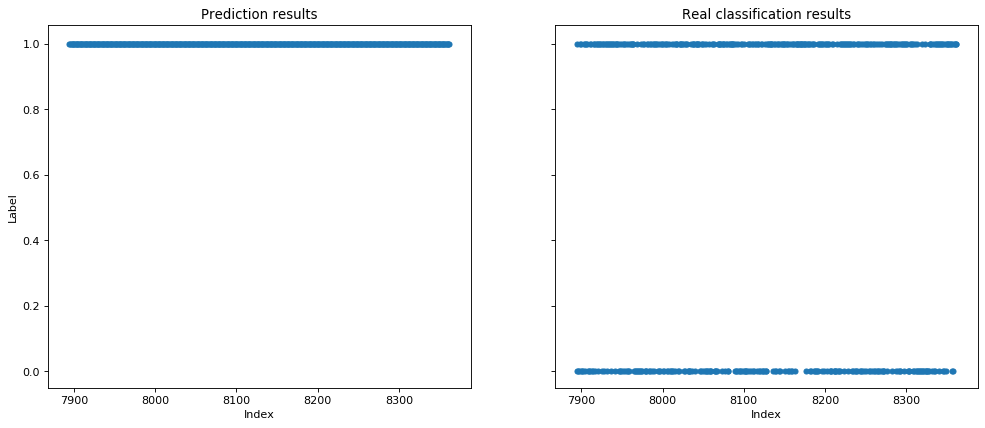

In [14]:
compare_prediction_visual(create_predictions_dataset(test_df, linear_model,X_test), result_test_df, 'Linear')

### Logistic Regression Model

In [15]:
# import function
from sklearn.linear_model import LogisticRegression

Metrics for model: Logistic model
	Score: 0.58
	Accuracy: 0.58
	Precision: 0.58
	Recall: 1.00
	Predicts 57.78% time it the stock price goes up
	Confusion matrix: 
	[  0 197] 
	[  1 271]


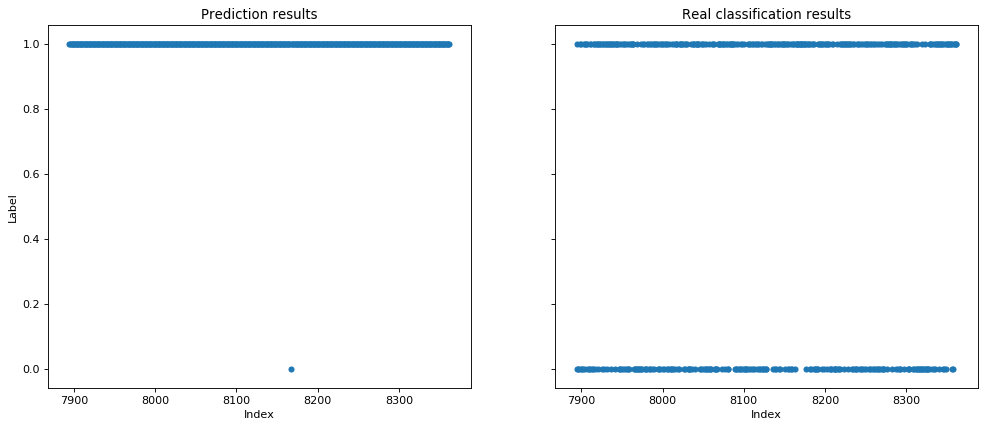

In [16]:
# create model
logistic_model = LogisticRegression(random_state=0, solver='liblinear')
# train model
logistic_model.fit(X_train,y_train)
get_model_metrics(logistic_model, y_test, X_test, 'Logistic model')
compare_prediction_visual(create_predictions_dataset(test_df, logistic_model,X_test), result_test_df, 'Logistic')

# Hyperparam optimization

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

Best parameters for logistic model grid {'C': 50.0, 'class_weight': 'balanced', 'max_iter': 100}
Best score : 0.48
Score for logistic regression - version 2 : 0.47
Metrics for model: Logistic model grid
	Score: 0.47
	Accuracy: 0.47
	Precision: 0.57
	Recall: 0.35
	Predicts 46.91% time it the stock price goes up
	Confusion matrix: 
	[124  73] 
	[176  96]


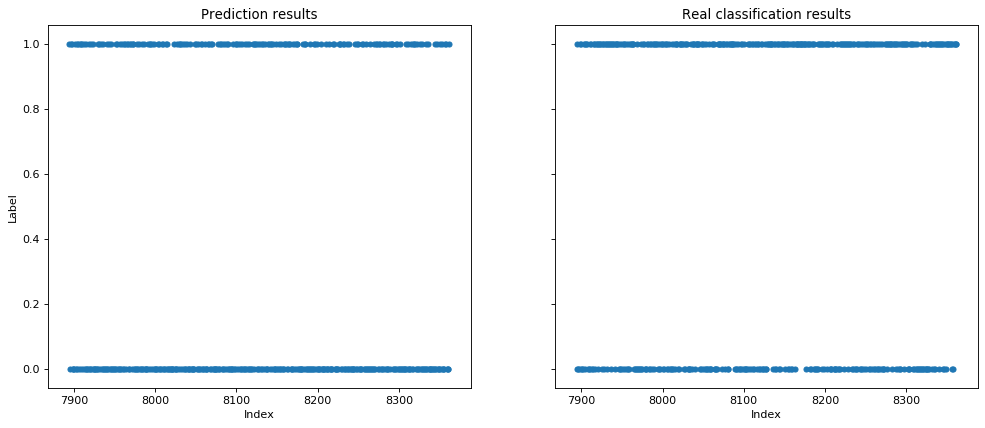

In [18]:
#This takes several minutes
parameters = {'C':[50.0],'class_weight' : ['balanced'], 'max_iter' : [100]}
logistic_model_grid = GridSearchCV(logistic_model, param_grid=parameters, cv=3)

with ignore_warnings(category=ConvergenceWarning):
    logistic_model_grid.fit(X_train, y_train)
    
print ('Best parameters for logistic model grid {}'.format(logistic_model_grid.best_params_))

print ('Best score : {0:.2f}'.format(logistic_model_grid.best_score_))
print ('Score for logistic regression - version 2 : {0:.2f}'.format(logistic_model_grid.score(X_test, y_test)))

get_model_metrics(logistic_model_grid, y_test, X_test, 'Logistic model grid')
compare_prediction_visual(create_predictions_dataset(test_df, logistic_model_grid, X_test), result_test_df, 'Logistic Grid')

# feature standardization

In [19]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [20]:
# feature standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled[:,0].min(),X_train_scaled[:,0].max()

(-0.861998280708464, 2.775096881210145)

Best parameters for logistic model grid {'C': 50.0, 'class_weight': 'balanced', 'max_iter': 100}
Best score : 0.86
Score for logistic regression - version 2 : 0.83
Metrics for model: Logistic model grid
	Score: 0.83
	Accuracy: 0.83
	Precision: 0.86
	Recall: 0.85
	Predicts 83.16% time it the stock price goes up
	Confusion matrix: 
	[160  37] 
	[ 42 230]


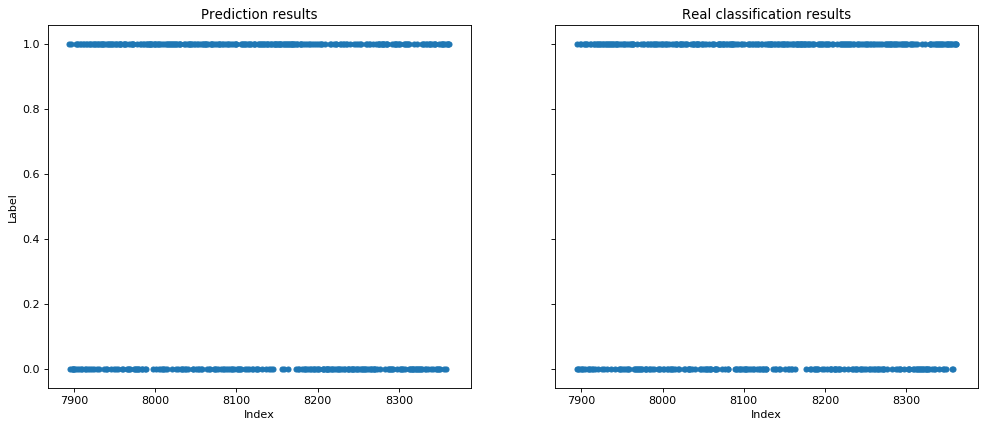

In [21]:
parameters = {'C':[50.0],'class_weight' : ['balanced'], 'max_iter' : [100]}
logistic_model_grid = GridSearchCV(logistic_model, param_grid=parameters, cv=3)

with ignore_warnings(category=ConvergenceWarning):
    logistic_model_grid.fit(X_train_scaled, y_train)
    
print ('Best parameters for logistic model grid {}'.format(logistic_model_grid.best_params_))

print ('Best score : {0:.2f}'.format(logistic_model_grid.best_score_))
print ('Score for logistic regression - version 2 : {0:.2f}'.format(logistic_model_grid.score(X_test_scaled, y_test)))

get_model_metrics(logistic_model_grid, y_test, X_test_scaled, 'Logistic model grid')
compare_prediction_visual(create_predictions_dataset(test_df, logistic_model_grid, X_test_scaled), result_test_df, 'Logistic Grid')

# Random Forest Model

In [22]:
from sklearn.ensemble import RandomForestClassifier

Using no scaled dataset
Metrics for model: Random forest model
	Score: 0.71
	Accuracy: 0.71
	Precision: 0.85
	Recall: 0.60
	Predicts 70.58% time it the stock price goes up
	Confusion matrix: 
	[169  28] 
	[110 162]


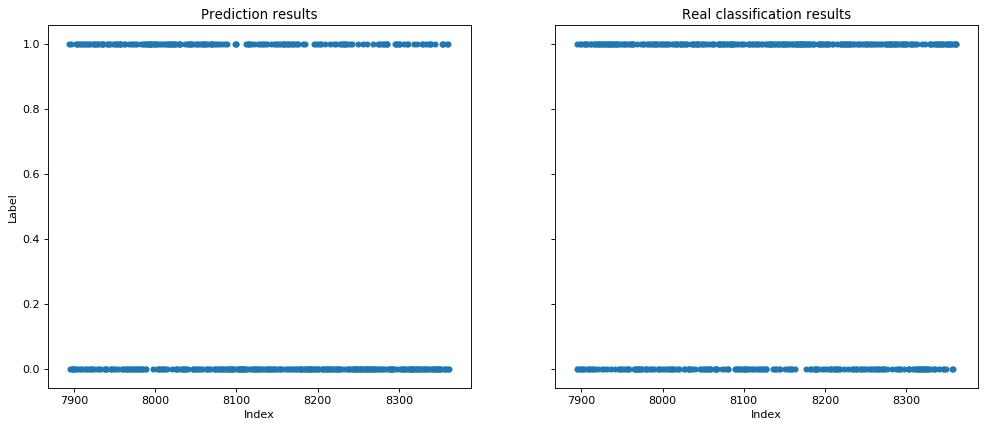

In [23]:
print("Using no scaled dataset")
# create model
random_forest = RandomForestClassifier(random_state=0,n_estimators=10)
# train model
random_forest.fit(X_train, y_train)
# evaluate model
get_model_metrics(random_forest, y_test, X_test, 'Random forest model')
compare_prediction_visual(create_predictions_dataset(test_df, random_forest,X_test), 
                          result_test_df, 'Random forest')


Using scaled dataset
Metrics for model: Random forest model - Scaled
	Score: 0.70
	Accuracy: 0.70
	Precision: 0.85
	Recall: 0.59
	Predicts 70.36% time it the stock price goes up
	Confusion matrix: 
	[169  28] 
	[111 161]


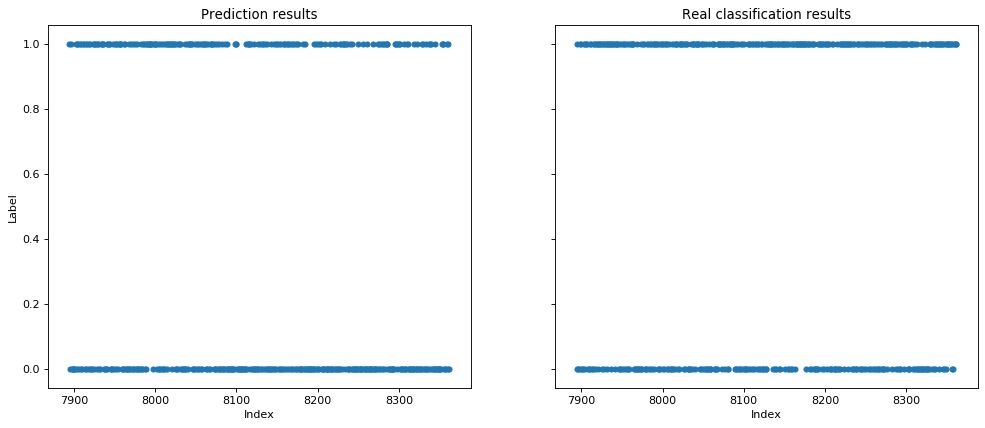

In [24]:
print("Using scaled dataset")
# create model
random_forest_scaled = RandomForestClassifier(random_state=0,n_estimators=10)
# train model
random_forest_scaled.fit(X_train_scaled, y_train)
# evaluate model
get_model_metrics(random_forest_scaled, y_test, X_test_scaled, 'Random forest model - Scaled')
compare_prediction_visual(create_predictions_dataset(test_df, random_forest_scaled, X_test_scaled), 
                          result_test_df, 'RandomForestModel-Scaled')


# Hyperparameters optimization

Best parameters for random forest model grid {'max_features': 'auto', 'min_samples_leaf': 50, 'n_estimators': 100}
Score for random forest: 0.84
Metrics for model: Random Forest grid search
	Score: 0.84
	Accuracy: 0.84
	Precision: 0.86
	Recall: 0.86
	Predicts 83.58% time it the stock price goes up
	Confusion matrix: 
	[159  38] 
	[ 39 233]


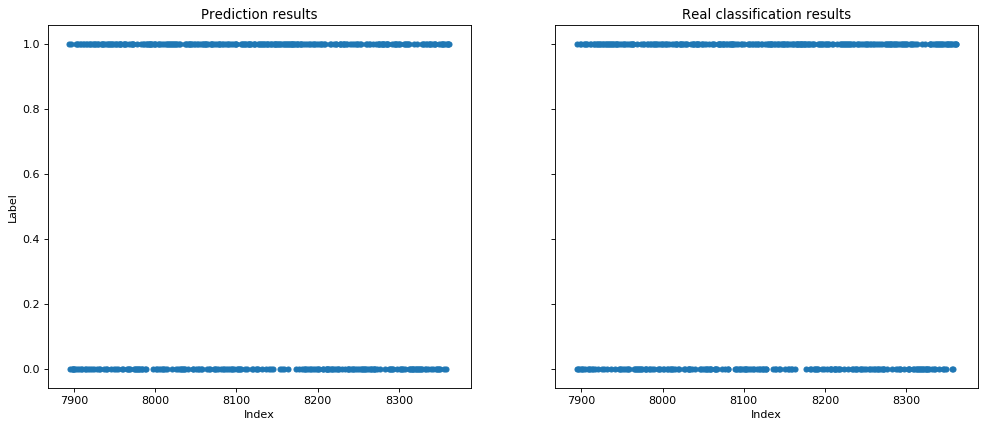

In [25]:
parameters = {'n_estimators':[50, 100, 200,1000], 
              'min_samples_leaf':[1, 5,10,50],
              'max_features' : ('auto','sqrt','log2'),
               }
rf = RandomForestClassifier(random_state=0, oob_score=True)
rf_grid = GridSearchCV(rf, parameters, cv=5)

with ignore_warnings(category=ConvergenceWarning):
    rf_grid.fit(X_train, y_train)
    
print ('Best parameters for random forest model grid {}'.format(rf_grid.best_params_))

print ('Score for random forest: {0:.2f}'.format(rf_grid.score(X_test, y_test)))

get_model_metrics(rf_grid, y_test, X_test, 'Random Forest grid search')
compare_prediction_visual(create_predictions_dataset(test_df, rf_grid, X_test), result_test_df, 'RandomForestGrid')

# Light GBM

In [26]:
# !pip install lightgbm
# !brew install libomp
# !brew upgrade libomp

In [27]:
from lightgbm import LGBMClassifier

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Generate scripts to run on google cloud

In [28]:
logistic_model_script_file = os.path.join(os.path.pardir,'src','models','logistic_model.py')
print(logistic_model_script_file)
prediction_utils_script_file = os.path.join(os.path.pardir,'src','models','prediction_utils.py')
print(prediction_utils_script_file)


../src/models/logistic_model.py
../src/models/prediction_utils.py


In [29]:
%%writefile $logistic_model_script_file
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

import src.models.prediction_utils as utils

X_train, y_train, result_train_df = utils.create_train_matrix('dataset_feature_vector.csv')
X_test, y_test, result_test_df = utils.create_test_matrix('dataset_feature_vector.csv')

#Create model/estimator
logistic_model = LogisticRegression(random_state=0, solver='liblinear')

#This takes several minutes
parameters = {'C':[1.0, 10.0, 50.0, 100.0, 1000.0], 'penalty' : ['l1','l2'],'class_weight' : ['balanced',None], 'solver' : ['liblinear','saga'], 'max_iter' : [100,1000,10000]}
logistic_model_grid = GridSearchCV(logistic_model, param_grid=parameters, cv=3)
#Train every posible variation of the model
with ignore_warnings(category=ConvergenceWarning):
    logistic_model_grid.fit(X_train, y_train)

#Get the best    
print ('Best parameters for logistic model grid {}'.format(logistic_model_grid.best_params_))
print ('Best score : {0:.2f}'.format(logistic_model_grid.best_score_))
print ('Score for logistic regression - version 2 : {0:.2f}'.format(logistic_model_grid.score(X_test, y_test)))

utils.get_model_metrics(logistic_model_grid, y_test, X_test, 'Logistic model grid')
utils.compare_prediction_visual(utils.create_predictions_dataset(result_test_df, logistic_model_grid, X_test), result_test_df, 'Logistic Grid')




Overwriting ../src/models/logistic_model.py


In [30]:
%%writefile $prediction_utils_script_file
import pandas as pd
import warnings
import sklearn
import datetime
import matplotlib.pyplot as plt     
from matplotlib.pyplot import figure
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.utils.multiclass import unique_labels

import src.data.dataset_utils as utils
import src.data.processed_data as process

def create_predictions_dataset(test_df, model, X_test):
    predictions = model.predict(X_test)
    df_predicted = pd.DataFrame({ 'Label' : predictions, 'Index' : test_df.index} )
    return df_predicted


def compare_prediction_visual(df_predicted, df_real,model_name='Unknown model'):
    fig = figure(num=None, figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(121)
    title = model_name + ' ' +  'classification results'
    df_predicted.plot(kind='scatter', x='Index',y='Label',ax = plt.gca(),title=title)
    plt.subplot(122)
    df_real.plot(kind='scatter', x='Index',y='Label',ax = plt.gca() ,title='Real classification results')
    today = datetime.date.today()
    plt.savefig('{0}{1}.png'.format(model_name,today))


def get_model_metrics(model, y_test, X_test, model_name='Unknown model'):
    result = model.score(X_test, y_test)
    print ('Metrics for model: {}'.format(model_name))
    print ('\tScore: {1:.2f}'.format(model_name, result))
    print ('\tAccuracy: {0:.2f}'.format(accuracy_score(y_test, model.predict(X_test))))
    warnings.filterwarnings('ignore')
    print ('\tPrecision: {0:.2f}'.format(precision_score(y_test, model.predict(X_test))))
    print ('\tRecall: {0:.2f}'.format(recall_score(y_test, model.predict(X_test))))
    print ('\tPredicts {0:.2f}% time it the stock price goes up'.format(result*100, model_name))
    cm = confusion_matrix(y_test, model.predict(X_test))
    print( '\tConfusion matrix: \n\t{0} \n\t{1}'.format(cm[0], cm[1]))

    
def create_train_matrix(file, data_type='processed', predicted_variable='Label'):
    dataset = utils.load_dataset('',file, data_type)
    train_df, result_train_df = process.generate_train_dataset_lowerbound(dataset)
    X_train = train_df.values.astype('float')
    y_train = result_train_df[predicted_variable].ravel()
    print (y_train.shape)
    print (X_train.shape)
    
    return X_train, y_train, result_train_df


def create_test_matrix(file, data_type='processed', predicted_variable='Label'):
    dataset = utils.load_dataset('',file, data_type)
    test_df, result_test_df = process.generate_test_dataset(dataset)
    X_test = test_df.values.astype('float')
    y_test = result_test_df['Label'].ravel()
    print (y_test.shape)
    print (X_test.shape)
    
    return X_test, y_test, result_test_df


    

Overwriting ../src/models/prediction_utils.py
